# Plotting Interpolation for ControlNet

In [1]:
# Modules
import torch
import torchvision
import torchvision.utils as vutils

import numpy as np

import os

#plotting
import matplotlib.pyplot as plt

from PIL import Image

from torch_geometry.metrics import euclidean_energy

In [8]:
image_type = "bedroom"
image_path = "sample_results"
methods = ["ProbGEORCE_D", "ProbGEORCE_N", "linear", "slerp", "noisediffusion", "noise"]
figure_path = f'../figures/'

## Loading Images

In [9]:
def convert_to_torch(img):

    if img.mode == 'RGBA':#
        img = img.convert('RGB')
    img = torch.tensor(np.array(img), dtype=torch.float32).permute(2,0,1).unsqueeze(0)

    return img

In [10]:
img1 = Image.open(f'sample_imgs/{image_type}1.png').resize((768, 768))
img2 = Image.open(f'sample_imgs/{image_type}2.png').resize((768, 768))

In [11]:
img1 = convert_to_torch(img1)
img2 = convert_to_torch(img2)

In [12]:
save_path = ''.join((image_path, f'/{image_type}', '/'))    
onlyfolders = [f for f in os.listdir(save_path) if not os.path.isfile(os.path.join(save_path, f))]

In [13]:
curves = {}
for folder in onlyfolders:
    subpath = ''.join((image_path, f'/{image_type}/{folder}'))
    onlyfiles = [f for f in os.listdir(subpath) if (os.path.isfile(os.path.join(subpath, f)) and "png" in f)]
    j = 0
    vals = []
    while True:
        file = f'{j}.png'
        if file in onlyfiles:
            img = Image.open(''.join((subpath, f'/{file}'))).resize((786,786))
            img = convert_to_torch(img)
            vals.append(img)
        else:
            break
        j += 1
    curves[folder] = torch.stack(vals)

## Plotting

### Full Plot

In [14]:
data_curves = []
for key, val in curves.items():
    data_curves.append(val)
data_curves = torch.stack(data_curves)

/tmp/ipykernel_105378/1955804893.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))


torch.Size([88, 3, 786, 786])


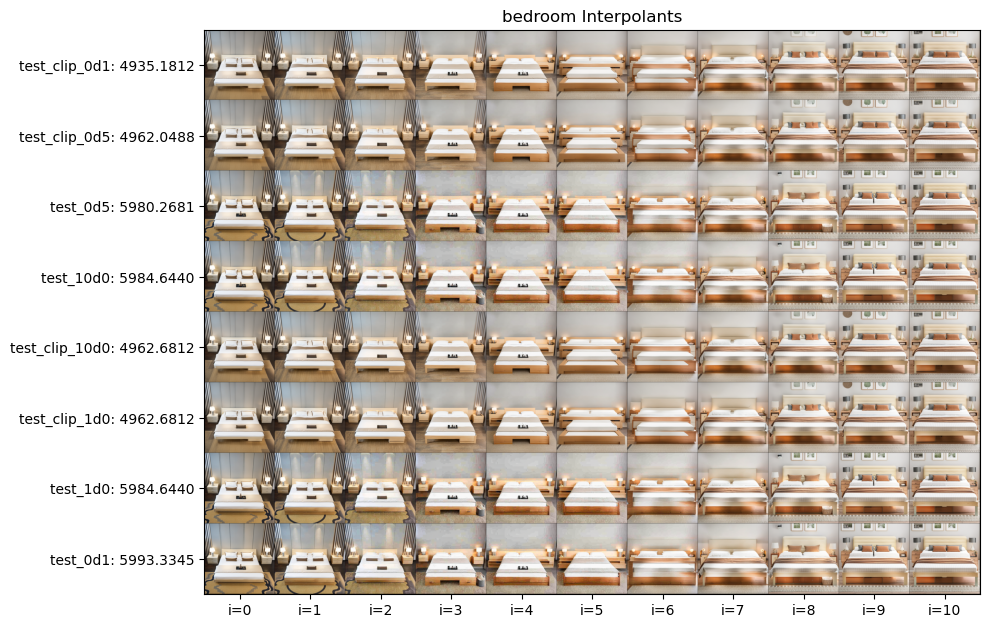

In [15]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{k}: {(euclidean_energy(val)/(768*786*3)):.4f}" for k,val in curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"i={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"{image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
print(plot_val.shape)
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_all.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

### Illustration

In [10]:
plot_type = ['ProbGEORCE_0d1', 'ProbGEORCE_0d5', 'ProbGEORCE_1d0', 'ProbGEORCE_10d0']

In [11]:
data_curves = []
for p_type in plot_type:
    for key, val in curves.items():
        if key == p_type:
            data_curves.append(val)
data_curves = torch.stack(data_curves)

In [12]:
single_curves = {}
for pt in plot_type:
    for k,v in curves.items():
        if k == pt:
            single_curves[k] = v

/tmp/ipykernel_73201/2096854778.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))


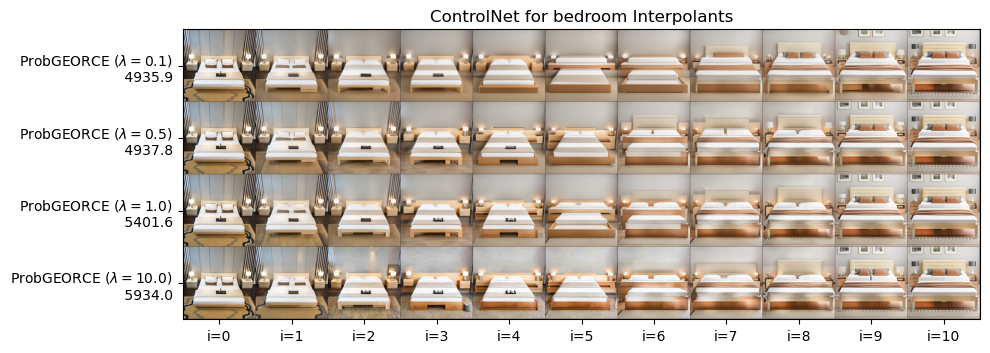

In [13]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{k.replace('_D','').replace('d', '.').replace('_',r' ($\lambda=$')}) \n {(euclidean_energy(val)/(768*786*3)):.1f}" for k,val in single_curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"i={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"ControlNet for {image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_lambda.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

## Comparison

In [21]:
plot_type = {'Linear': 'Linear', 
             'Spherical': 'Spherical', 
             'Noise': 'Noise', 
             'NoiseDiffusion': 'NoiseDiffusion',
             #'ProbGEORCE_clip_0d1': r'ProbGEORCE ($\lambda=0.1$)', 
             #'ProbGEORCE_clip_0d5': r'ProbGEORCE ($\lambda=0.5$)', 
             'ProbGEORCE_clip_1d0': r'ProbGEORCE ($\lambda=1.0$)', 
             #'ProbGEORCE_clip_10d0': r'ProbGEORCE ($\lambda=10.0$)', 
            }

In [22]:
data_curves = []
for p_type in plot_type.keys():
    for key, val in curves.items():
        if key == p_type:
            data_curves.append(val)
data_curves = torch.stack(data_curves)

In [23]:
single_curves = {}
for pt in plot_type:
    for k,v in curves.items():
        if k == pt:
            single_curves[k] = v

/tmp/ipykernel_73201/2118361990.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))


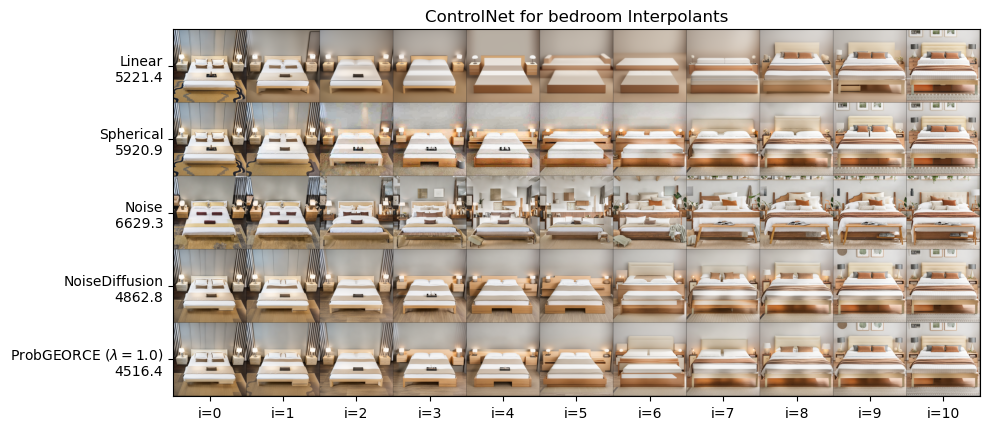

In [25]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{plot_type[k]}\n{(euclidean_energy(val)/(768*786*3)):.1f}" for k,val in single_curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"i={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"ControlNet for {image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_comparison.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

## Comparison to Noise Diffusion

In [41]:
mu_vals = [0.5, 1.0]
plot_type = {}
for mu in mu_vals:
    mu_str = str(mu).replace('.','d')
    plot_type[f'ProbGEORCE_ND_clip_1d0_{mu_str}_{mu_str}'] = fr'ProbGEORCE_ND ($\lambda=1.0$, $\mu=\nu={mu}$)'
    plot_type[f'NoiseDiffusion_clip_{mu_str}_{mu_str}'] = fr'NoiseDiffusion ($\mu=\nu={mu}$)'

In [42]:
data_curves = []
for p_type in plot_type.keys():
    for key, val in curves.items():
        if key == p_type:
            data_curves.append(val)
data_curves = torch.stack(data_curves)

In [43]:
single_curves = {}
for pt in plot_type:
    for k,v in curves.items():
        if k == pt:
            single_curves[k] = v

/tmp/ipykernel_73201/1541828870.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))


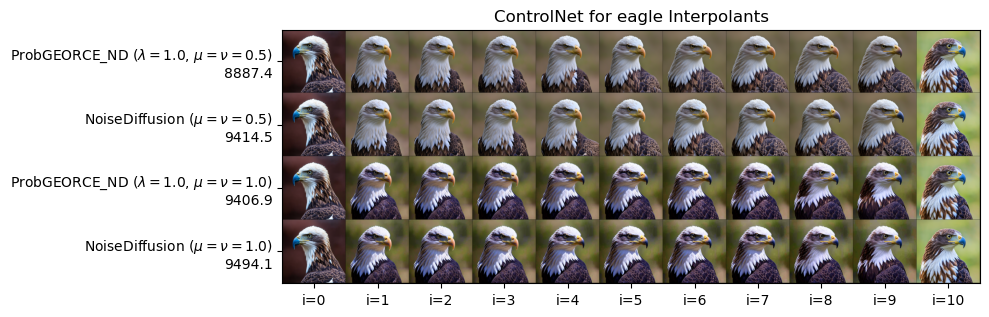

In [44]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{plot_type[k]}\n{(euclidean_energy(val)/(768*786*3)):.1f}" for k,val in single_curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"i={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"ControlNet for {image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_comparison_to_noise_diffusion.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')